In [1]:
%pip install davos
import davos

%conda install pytables

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle nltools as nlt            # pip: nltools==0.4.7

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.colors smuggle ListedColormap

smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from scipy.stats smuggle spearmanr
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings
from glob import glob as lsdir

from helpers import nii2cmu, cmu2nii, conditions, condition_colors, figdir, basedir, datadir, scratch_dir, group_pca, get_data, rbf

Fetch/load the HTFA posterior

In [3]:
data = get_data()

Load a neurosynth topic map to use as a template

In [4]:
neurosynth_dir = os.path.join(datadir, 'neurosynth')
nii_fname = os.path.join(neurosynth_dir, 'topic0_pFgA_z.nii.gz')
template = nii2cmu(nii_fname)

Compute the HTFA factor images matrix:
  - Rows: factors
  - Columns: voxels in the template brain

In [5]:
factors = []
for c, w in zip(data['centers'], data['widths']):
    factors.append(np.atleast_2d(rbf(template['R'], c, w)).T)

F = np.hstack(factors).T

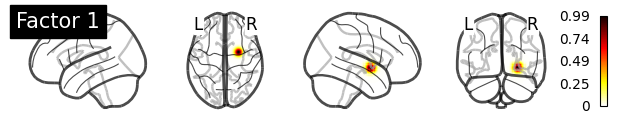

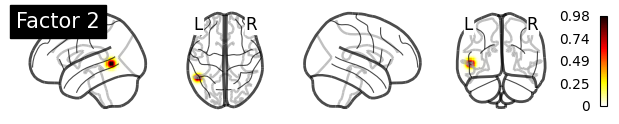

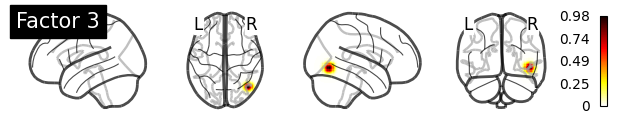

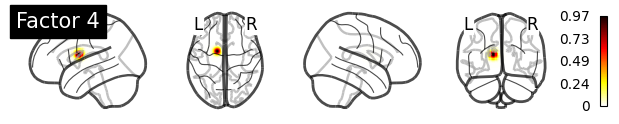

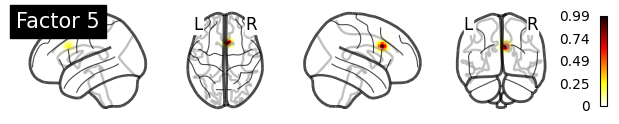

In [6]:
# plot some sample factors

for i in range(5):
    nl.plotting.plot_glass_brain(cmu2nii(F[i, :], template['R'], nii_fname), colorbar=True, title=f'Factor {i+1}', display_mode='lzry', figure=plt.figure(figsize=(6, 1)))

Compress each condition using group PCA

In [7]:
# number of components to plot/decode
k = 5

components = {}
for c in conditions:
    _, model = group_pca(data['weights'][c], n_components=k)
    X = model.components_
    components[c] = [cmu2nii(np.dot(np.atleast_2d(X[i, :]), F), template['R'], nii_fname) for i in range(k)]

Plot the component images

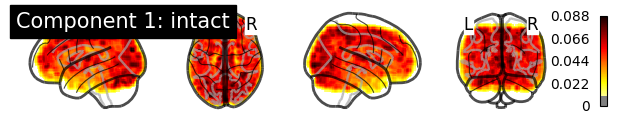

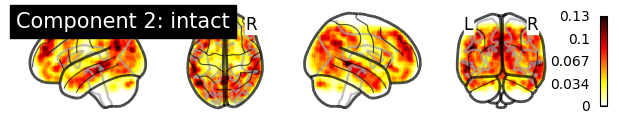

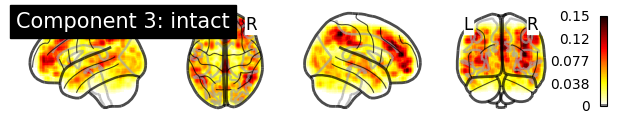

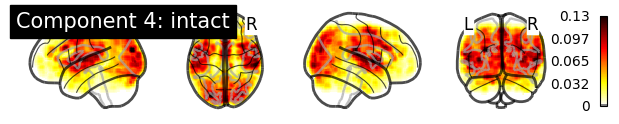

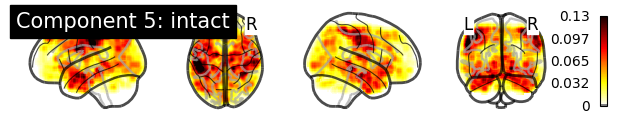

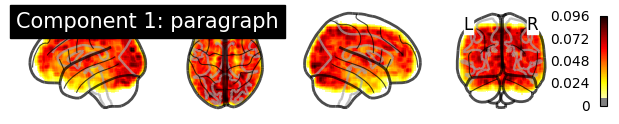

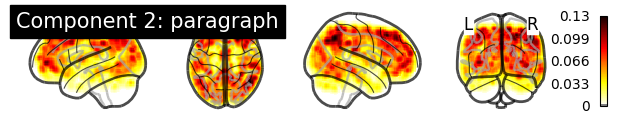

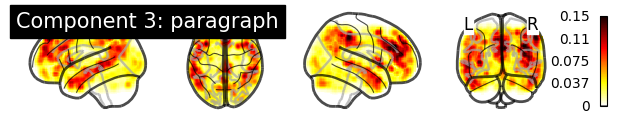

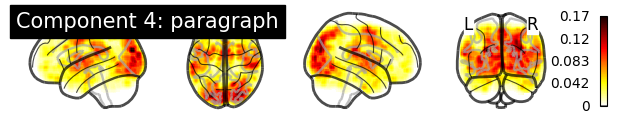

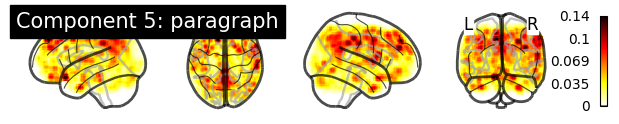

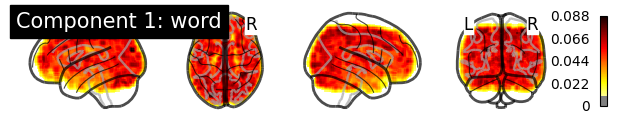

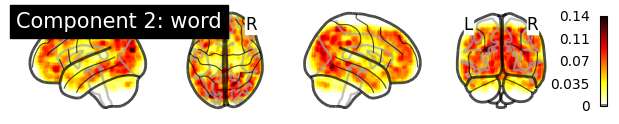

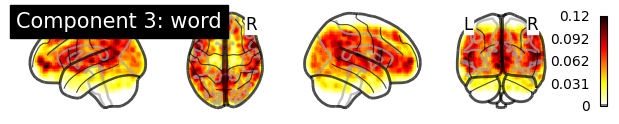

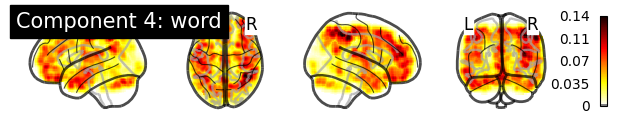

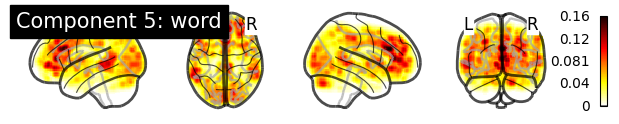

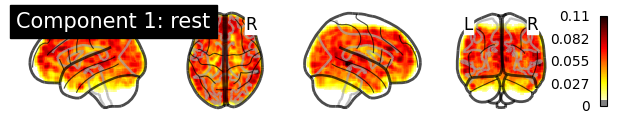

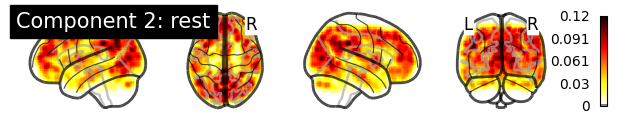

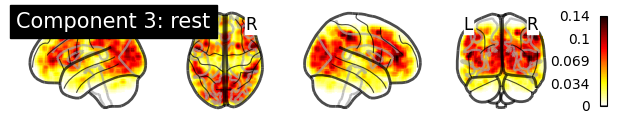

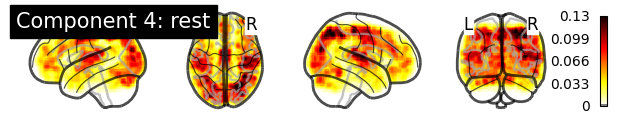

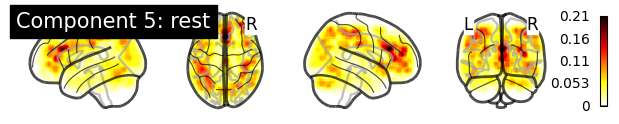

In [8]:
for c in conditions:
    for i in range(k):
        nl.plotting.plot_glass_brain(components[c][i], colorbar=True, title=f'Component {i+1}: {c}', display_mode='lzry', figure=plt.figure(figsize=(6, 1)))

Neurosynth decoding

References:

1. Fox AS, Chang LJ, Gorgolewski KJ, Yarkoni T (2014) [Bridging psychology and genetics using large-scale spatial analysis of neuroimaging and neurogenetic data](https://www.biorxiv.org/content/10.1101/012310v1.abstract).  bioRxiv: doi.org/10.1101/012310

2. Sul S, Güroğlu B, Crone EA, Chang LJ (2017) [Medial prefrontal cortical thinning mediates shifts in other-regarding preferences during adolescence](https://www.nature.com/articles/s41598-017-08692-6.epdf?shared_access_token=axJA9l5exJBRRof-RbTwv9RgN0jAjWel9jnR3ZoTv0N5WG5h1jAaEDJCl6rCzAwqd-CrMFv4PhRKQOqdWcanXG1L9xI9ib0fpcZhug9nV9o7YHzsZYGg3z7ryrmh_WnnAsc0F9znsZb5nvUtDHpgoorMLCs8C0l4JJLYHDy4IV0%3D).  Scientific Reports, 7(8510): doi.org/10.1038/s41598-017-08692-6

3. Chen P-HA, Jolly E, Cheong JH, Chang LJ (2020) [Intersubject representational similarity analysis reveals individual
variations in affective experience when watching erotic movies](http://cosanlab.com/static/papers/Chen_2020_Neuroimage.pdf).  NeuroImage, 216(116851): doi.org/10.1016/j.neuroimage.2020.116851

In [9]:
topics = pd.read_csv(os.path.join(neurosynth_dir, 'topics.csv')).drop('Topic Number', axis=1)
topics['Topic Label'] = topics['Topic Label'].apply(lambda x: x.capitalize().replace('_', ' ') if type(x) == str else 'N/A')
topics

,Topic Label,Classification,Mean doc. weight,Term 1,Term 2,Term 3,Term 4,Term 5,Term 6,Term 7,...,Term 11,Term 12,Term 13,Term 14,Term 15,Term 16,Term 17,Term 18,Term 19,Term 20
0,N/A,NonPsychological,0.3172,tasks,control,network,conditions,comparison,performed,common,...,active,relative,underlying,distinct,substrates,cognitive,performing,process,shown,addition
1,N/A,NonPsychological,0.0502,age,adults,children,development,adolescents,aging,developmental,...,aged,maturation,adulthood,elderly,reduced,adolescent,ages,late,developing,range
2,Eye movement,Exclude,0.0170,eye,gaze,eyes,visual,saccades,movements,saccade,...,fixation,guided,pursuit,oculomotor,movement,walking,saccadic,control,closed,direct
3,Recognition,Exclude,0.0182,recognition,familiar,identity,unfamiliar,voice,familiarity,route,...,atl,famous,person,names,perception,people,expression,discrimination,personally,condition
4,Context,Exclude,0.0169,context,game,human,interaction,ppi,contextual,contexts,...,cooperation,behavior,psychophysiological,avh,trust,partners,played,computer,virtual,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Auditory,Exclude,0.0317,speech,language,auditory,production,perception,comprehension,listening,...,sounds,native,bilinguals,spoken,speakers,languages,prosodic,voice,phonetic,speaker
76,N/A,NonPsychological,0.3351,network,evidence,human,systems,support,process,distinct,...,role,distributed,perceptual,domain,current,underlying,interaction,interactions,representation,remains
77,N/A,NonPsychological,0.1013,standard,images,individual,time,image,voxel,spatial,...,sensitivity,spm,space,roi,measures,provide,reliability,reliable,multiple,echo
78,Motion,Exclude,0.0349,motion,visual,perception,perceptual,biological,dynamic,moving,...,stimulus,psts,direction,sensitive,discrimination,cues,form,shape,depth,viewing


Exclude topics with non-psychological themes

In [10]:
topics = topics.query('`Topic Label` != "N/A"').drop('Classification', axis=1)
topics

,Topic Label,Mean doc. weight,Term 1,Term 2,Term 3,Term 4,Term 5,Term 6,Term 7,Term 8,...,Term 11,Term 12,Term 13,Term 14,Term 15,Term 16,Term 17,Term 18,Term 19,Term 20
2,Eye movement,0.0170,eye,gaze,eyes,visual,saccades,movements,saccade,direction,...,fixation,guided,pursuit,oculomotor,movement,walking,saccadic,control,closed,direct
3,Recognition,0.0182,recognition,familiar,identity,unfamiliar,voice,familiarity,route,voices,...,atl,famous,person,names,perception,people,expression,discrimination,personally,condition
4,Context,0.0169,context,game,human,interaction,ppi,contextual,contexts,agency,...,cooperation,behavior,psychophysiological,avh,trust,partners,played,computer,virtual,online
5,Semantic,0.0415,semantic,words,word,lexical,verbal,language,tasks,naming,...,decision,frequency,picture,retrieval,meaning,knowledge,semantically,pictures,relative,recognition
8,Motor,0.0617,motor,movement,movements,sensorimotor,primary,finger,control,imagery,...,tasks,tapping,coordination,somatosensory,performed,bimanual,mi,simple,planning,ipsilateral
9,Illicit substances,0.0102,cocaine,users,drug,bpd,controls,cannabis,addiction,craving,...,dependence,awareness,abuse,mj,abusers,chronic,pg,marijuana,addicts,abstinence
10,Music,0.0123,music,musical,pitch,auditory,musicians,sequences,rhythm,listening,...,vocal,rhythmic,melody,training,tones,tone,timing,perception,sequence,motor
14,Somatosensory,0.0320,stimulation,somatosensory,tms,tactile,primary,touch,motor,rtms,...,ipsilateral,muscle,secondary,representation,induced,repetitive,stimulated,human,electrical,emg
15,Polymodal sensory,0.0526,auditory,visual,sensory,modality,sounds,integration,sound,stimulus,...,audiovisual,multisensory,modal,perception,input,responses,crossmodal,stimulation,unimodal,multimodal
16,Social,0.0260,social,empathy,experience,people,person,responses,perspective,individuals,...,infant,individual,exclusion,cultural,experiences,perception,viewing,affective,chinese,taking


Load in topic maps

In [11]:
topic_maps = [nii2cmu(os.path.join(neurosynth_dir, f'topic{i}_pFgA_z.nii.gz')) for i in topics.index.values]

Display some example maps

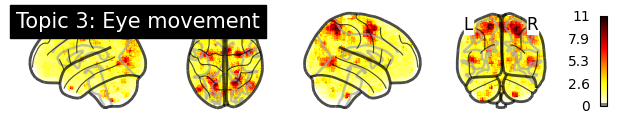

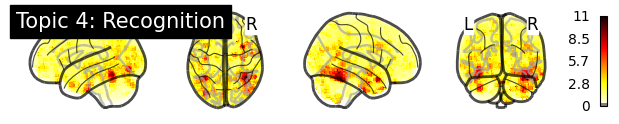

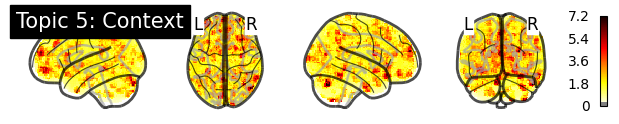

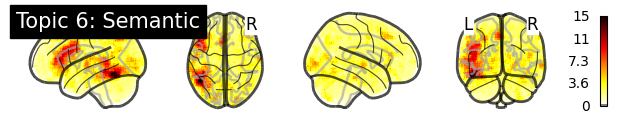

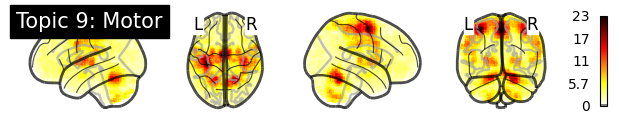

In [12]:
for i, topic in enumerate(topics.index.values[:5]):
    nl.plotting.plot_glass_brain(cmu2nii(topic_maps[i]['Y'], template['R'], nii_fname), colorbar=True, title=f'Topic {topic+1}: {topics.loc[topic]["Topic Label"]}', display_mode='lzry', figure=plt.figure(figsize=(6, 1)))

Convert component maps to CMU format

In [13]:
cmu_components = {}
for c in conditions:
    cmu_components[c] = [nii2cmu(x) for x in components[c]]

Use decoding procedure from [Sul et al. (2017)](https://www.nature.com/articles/s41598-017-08692-6.epdf?shared_access_token=axJA9l5exJBRRof-RbTwv9RgN0jAjWel9jnR3ZoTv0N5WG5h1jAaEDJCl6rCzAwqd-CrMFv4PhRKQOqdWcanXG1L9xI9ib0fpcZhug9nV9o7YHzsZYGg3z7ryrmh_WnnAsc0F9znsZb5nvUtDHpgoorMLCs8C0l4JJLYHDy4IV0%3D) to estimate topic weights from maps for each component and condition

In [14]:
def topic_weights(Y):
    raw_weights = np.array([spearmanr(topic_maps[i]['Y'], Y, nan_policy='omit', axis=1).statistic for i in range(len(topic_maps))])
    raw_weights[raw_weights < 0] = 0
    return raw_weights / raw_weights.sum()

In [15]:
df = []
for c in conditions:
    for i in tqdm(range(k)):
        weights = topic_weights(cmu_components[c][i]['Y'])

        for j in range(len(topic_maps)):
            x = pd.Series(dtype=object)
            x['Condition'] = c
            x['Component'] = i+1
            x['Topic'] = topics.iloc[j]['Topic Label']
            x['Weight'] = weights[j]
            df.append(pd.DataFrame(x).T)

df = pd.concat(df)

100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


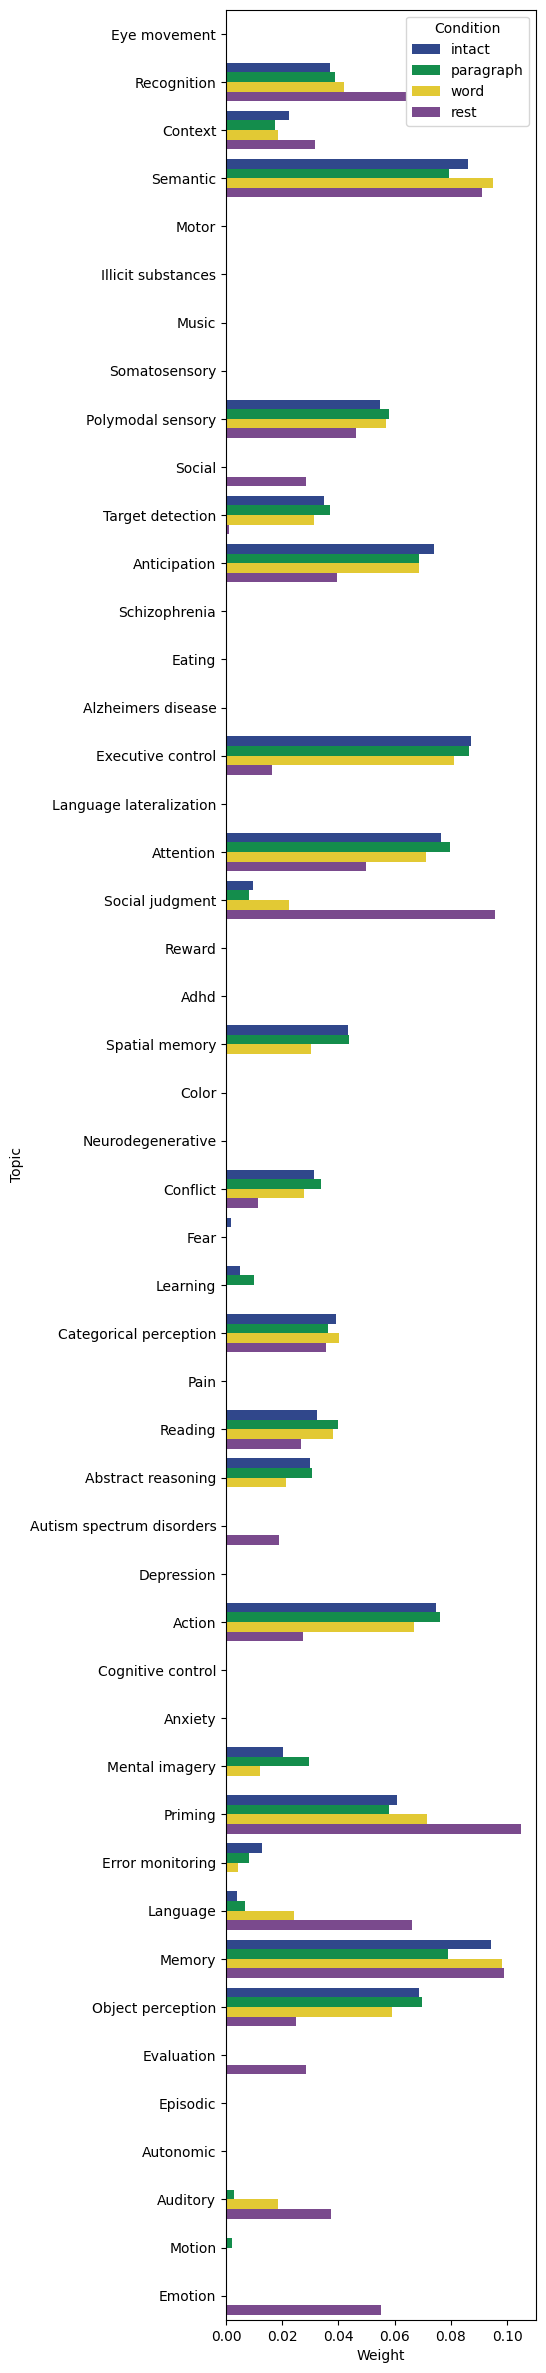

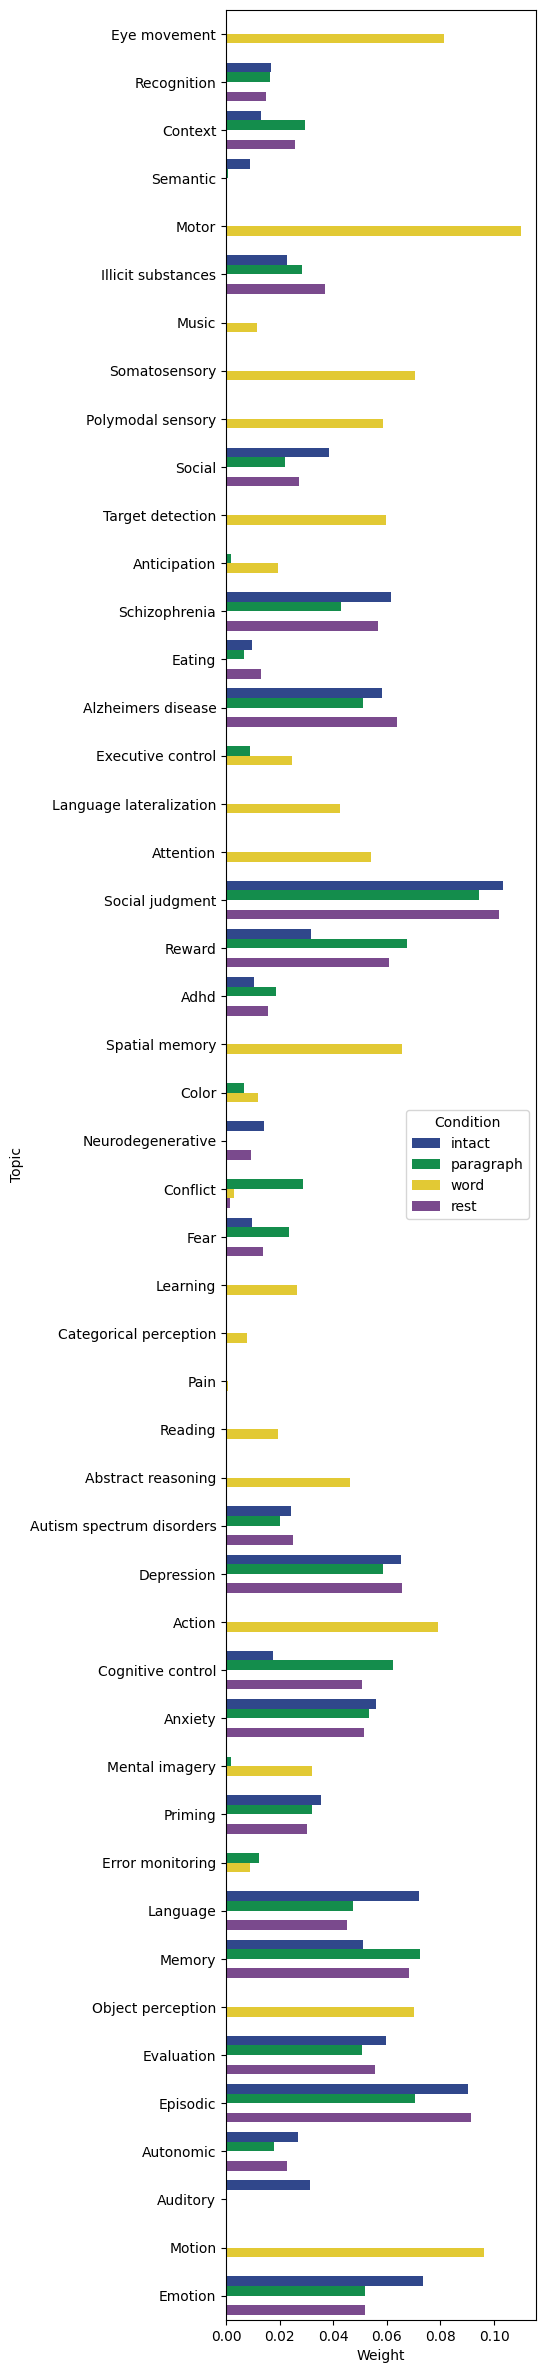

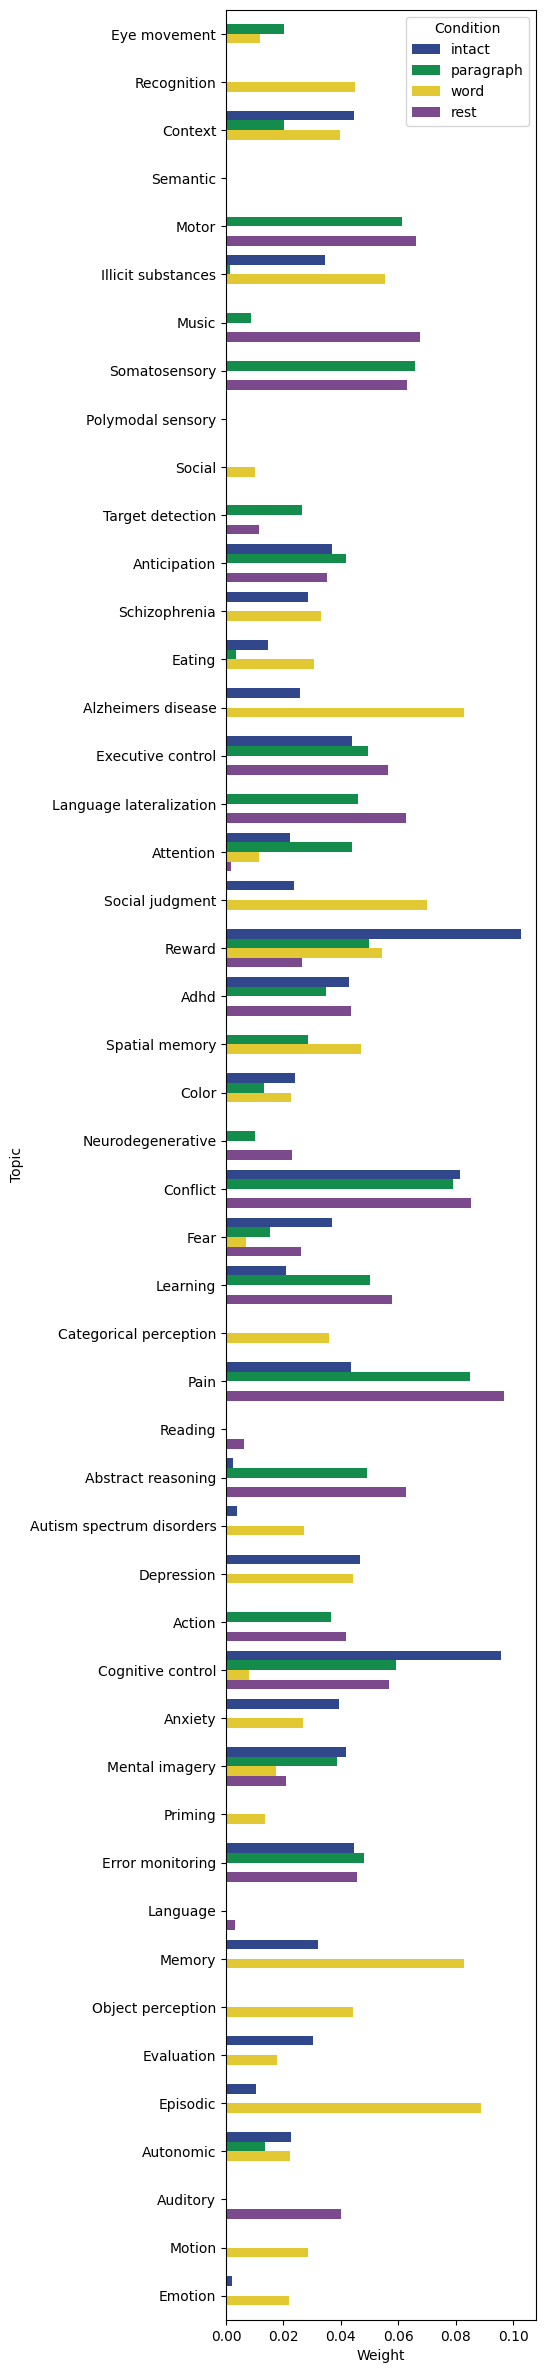

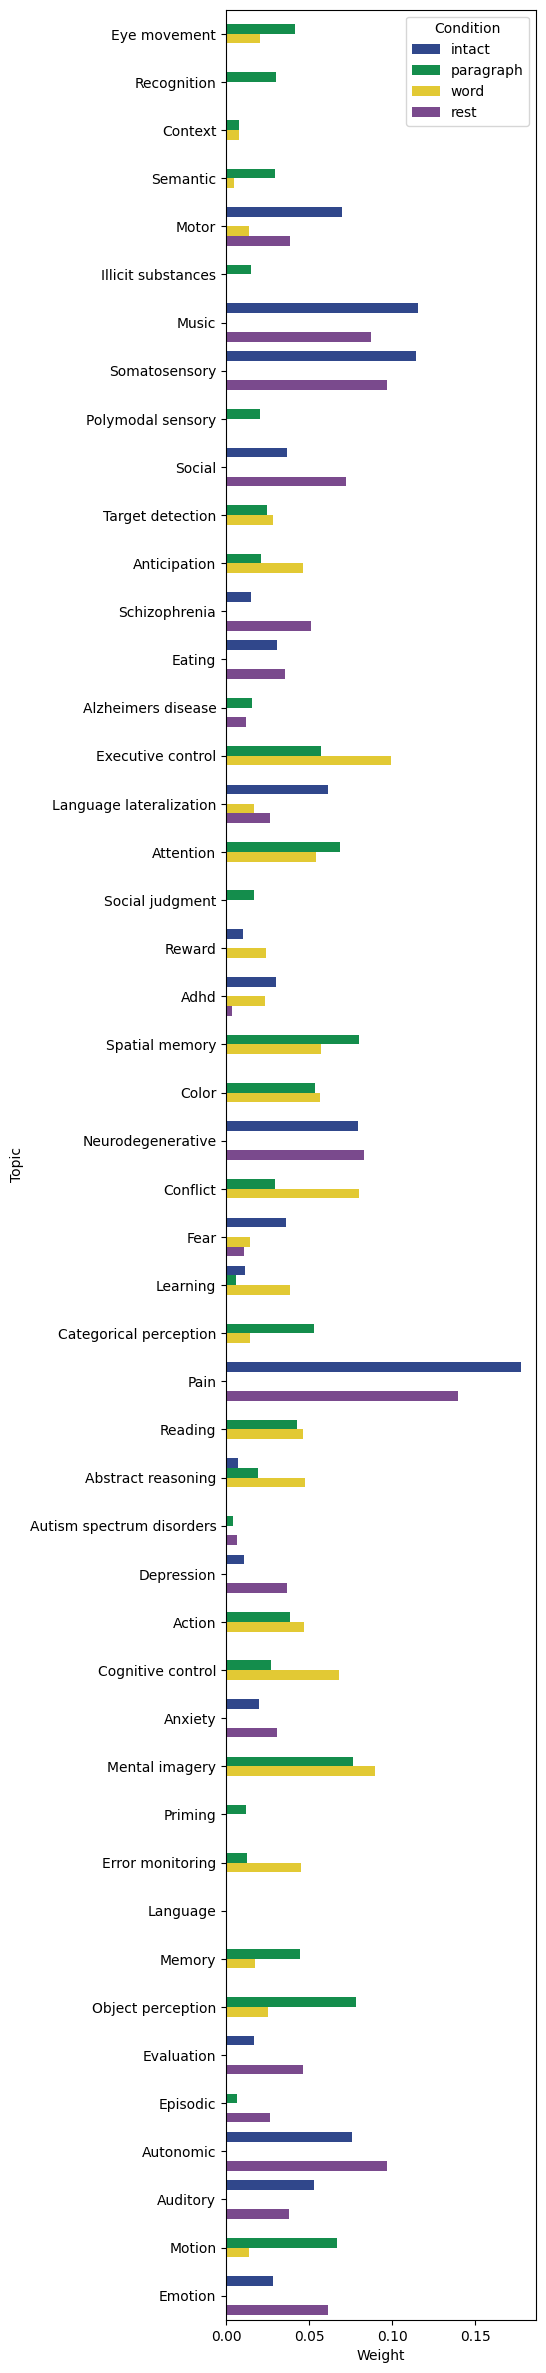

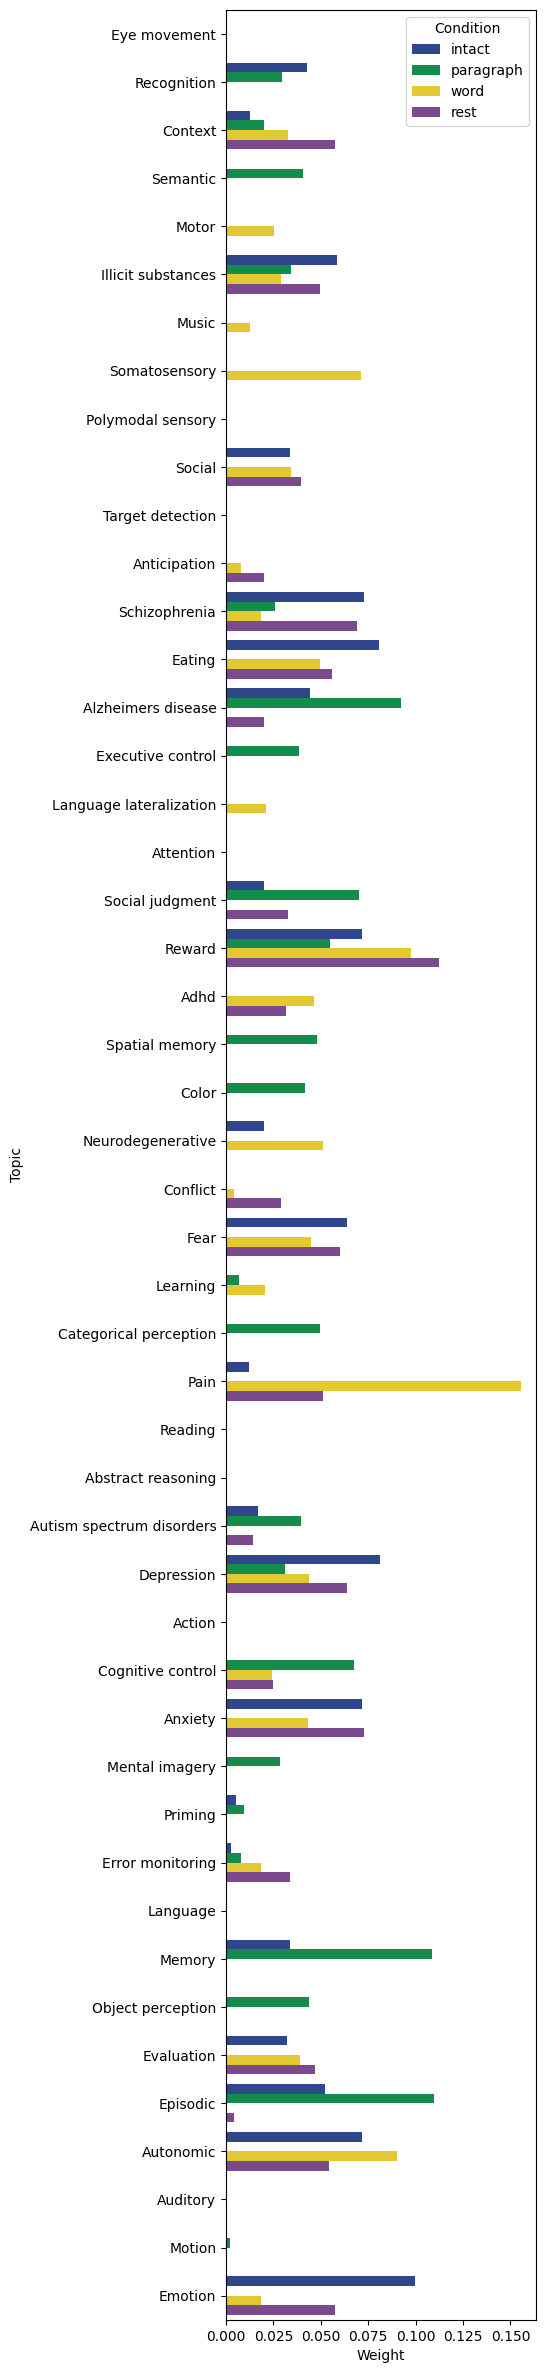

In [22]:
for i in range(1, k + 1):
    fig = plt.figure(figsize=(4, 30))
    sns.barplot(data=df.query('Component == @i'), y='Topic', x='Weight', hue='Condition', palette=[condition_colors[c] for c in conditions], edgecolor=None)